## Loading modules and the dataset

In [5]:
import pandas as pd
import bs4
import re

In [6]:
# Dataset
original_df = pd.read_csv("data/train.csv", delimiter=",")

## Linking the questions labels to the questions title
### Using the HTML file, we can access to labels questions which gathered additional information to know how to use these data

In [7]:
html_file = "data/USCODE22_LLCP_102523.HTML"
out_csv = "data/labels_questions.csv"

# Reading HTML 
with open(html_file, encoding="latin-1") as f:
    html = f.read()

soup = bs4.BeautifulSoup(html, "html.parser")

# Extracting blocks of questions
questions = []

for td in soup.find_all("td", class_="l m linecontent"):
    text = td.get_text(separator=" ", strip=True)
    text = text.replace("\xa0", " ")  
    text = re.sub(r"\s+", " ", text)

    # Extracting the different information
    label_match = re.search(r"Label:\s(.*?)\s+(?:Section Name:|Core Section Name:)", text, re.IGNORECASE)
    section_name_match = re.search(r"(?:Section Name:|Core Section Name:)\s(.*?)\s+(?:Section Number:|Core Section Number:|Module Number:)", text, re.IGNORECASE)
    section_number_match = re.search(r"(?:Section Number:|Core Section Number:|Module Number:)\s*([0-9A-Za-z]+)", text, re.IGNORECASE)
    sas_match = re.search(r"SAS Variable Name:\s*([A-Za-z0-9_]+)", text, re.IGNORECASE)

    questions.append({
        "Label": label_match.group(1).strip() if label_match else "",
        "Section Name": section_name_match.group(1).strip() if section_name_match else "",
        "Section Number": section_number_match.group(1).strip() if section_number_match else "", 
        "SAS_Variable_Name": sas_match.group(1).strip() if sas_match else ""
        })

# Conversion to df
labels_questions_df = pd.DataFrame(questions)

# Saving labels df
labels_questions_df.to_csv(out_csv, index=False, encoding="utf-8")

In [8]:
# Which are the different sections
labels_questions_df["Section Name"].unique()

array(['Record Identification', 'Land Line Introduction',
       'Cell Phone Introduction', 'Respondent Sex', 'Health Status',
       'Healthy Days', 'Health Care Access', 'Exercise',
       'Inadequate Sleep', 'Oral Health', 'Chronic Health Conditions',
       'Demographics', 'Disability',
       'Breast and Cervical Cancer Screening',
       'Colorectal Cancer Screening', 'Tobacco Use',
       'Lung Cancer Screening', 'Alcohol Consumption', 'Immunization',
       'HIV/AIDS', 'Long-term COVID Effects', 'Pre-Diabetes', 'Diabetes',
       'ME/CFS', 'Place of Flu Vaccination', 'HPV Vaccination',
       'Shingles Vaccination', 'COVID Vaccination', 'Respiratory Health',
       'Cancer Survivorship: Type of Cancer',
       'Cancer Survivorship: Course of Treatment',
       'Cancer Survivorship: Pain Management',
       'Prostate Cancer Screening', 'Cognitive Decline', 'Caregiver',
       'Adverse Childhood Experiences',
       'Social Determinants and Health Equity', 'Marijuana Use',
      

In [9]:
# Which are the different sections
len(labels_questions_df["Section Name"].unique())

56

In [15]:
# Suppression des colonnes entièrement NaN et mise à jour du label dataframe
cols_all_nan = original_df.columns[original_df.isna().all()].tolist()
original2_df = original_df.drop(cols_all_nan, axis=1)
labels2_questions_df = labels_questions_df[~labels_questions_df['SAS_Variable_Name'].isin(cols_all_nan)].reset_index(drop=True)
print(f"Removed {len(cols_all_nan)} features : from {original_df.shape[1]} to {original2_df.shape[1]}")

Removed 3 features : from 325 to 322


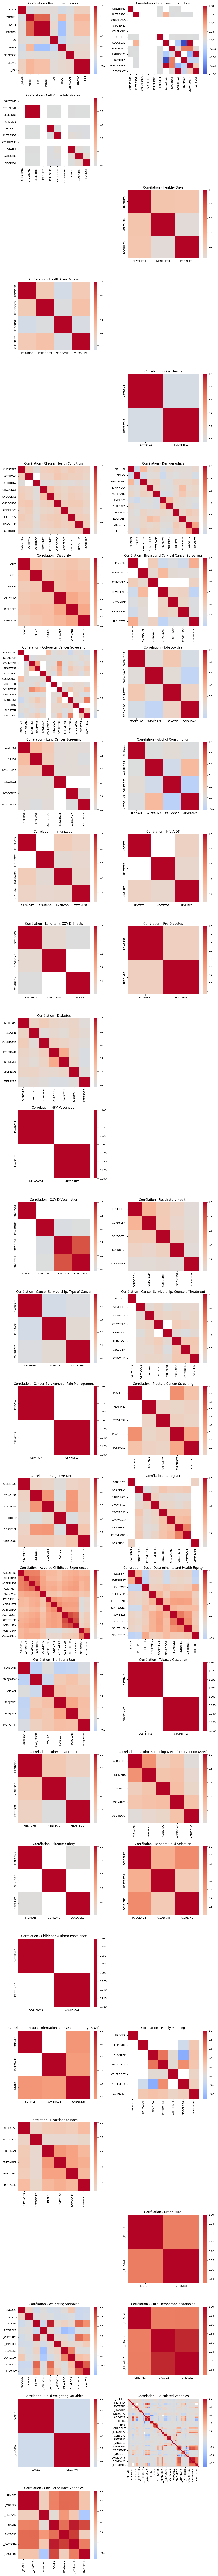

In [16]:
# Visualisation des matrices de corrélation par section sous forme de subplots
import matplotlib.pyplot as plt
import seaborn as sns

sections = [s for s in labels2_questions_df["Section Name"].unique() if s]
n_sections = len(sections)
n_cols = 2
n_rows = (n_sections + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten() if n_sections > 1 else [axes]

for idx, section in enumerate(sections):
    features = labels2_questions_df[labels2_questions_df["Section Name"] == section]["SAS_Variable_Name"].tolist()
    features = [f for f in features if f in original2_df.columns]
    if len(features) < 2:
        axes[idx].set_visible(False)
        continue
    corr = original2_df[features].corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm', center=0, ax=axes[idx])
    axes[idx].set_title(f"Corrélation - {section}")

# Masquer les subplots inutilisés
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()